-0.358384


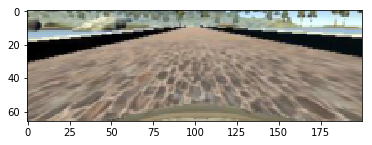

In [5]:
i=24198
image = X_train[i]
print(y_train[i])
plt.imshow(image)
plt.show()

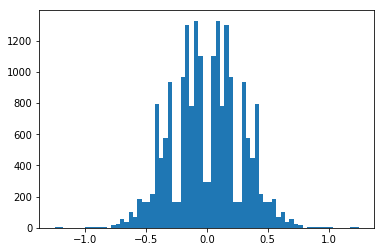

In [15]:
import matplotlib.pyplot as plt
plt.hist(y_train,70)
plt.show()

In [21]:
import numpy as np
import csv
import tensorflow as tf

tf.python.control_flow_ops = tf

#Train Parameter
epoch = 1
shift = 0.25 #Additional value to left and right camera
shape = (100,200) # Shape of resize before crop
validate_portion = 0.2
learning_rate = 0.001
data_create_or_load = 1 # 0: Create new Dataset/save 1: Load previous Dataset

#Model
from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
#from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.optimizers import Adam

def model():
    model = Sequential()
    elu = ELU(alpha=1.0)    
    model.add(Convolution2D(24, 5, 5,input_shape=(66, 200, 3),subsample=(2, 2),name='C1'))
    model.add(elu)
    model.add(Dropout(0.5))
    model.add(Convolution2D(36, 5, 5,subsample=(2, 2), name='C2'))
    model.add(elu)
    model.add(Dropout(0.5))
    model.add(Convolution2D(48, 5, 5,subsample=(2, 2),name='C3'))
    model.add(elu)
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, 3, 3,name='C4'))
    model.add(elu)
    model.add(Convolution2D(64, 3, 3,name='C5'))
    model.add(elu)
    model.add(Flatten())
    model.add(Dense(100,name='L1'))
    model.add(elu)
    model.add(Dense(50,name='L2'))    
    model.add(elu)
    model.add(Dense(10,name='L3'))
    model.add(Dense(1,name='L4'))
    return model

#Functions
from scipy.misc import imread
import scipy.misc as sp
def flip_merge(data):

    
    length = len(data['imgc'])
    X_train=[]
    y_train=[]
     
    for i in range(3):        
        if data[0][i]=='center':
            for i, loc in zip(range(length),data['imgc']):
                if(i==0):
                    continue
                else:
                    image = sp.imresize(imread(loc),size=shape)
                    X_train.append(image[30:96,:])                      
                    y_train.append(data['angle'][i])
                    print("Center camera resizing",i,"/",length-1)
                    
        elif data[0][i]=='left':
            for i, loc in zip(range(length),data['imgl']):
                if(i==0):
                    continue
                else:
                    image = sp.imresize(imread(loc),size=shape)
                    X_train.append(image[30:96,:])
                    y_train.append(data['angle'][i]+shift)
                    print("Left camera resizing",i,"/",length-1)
                    
        elif data[0][i]=='right':
            for i, loc in zip(range(length),data['imgr']):
                if(i==0):
                    continue
                else:
                    image = sp.imresize(imread(loc),size=shape)
                    X_train.append(image[30:96,:])         
                    y_train.append(data['angle'][i]-shift)
                    print("Right camera resizing",i,"/",length-1)            
                    
    print("Fliping..")    
    y_train = np.array(y_train).astype(np.float32)    
    a=[]
    for i in range(len(X_train)):
        a.append(np.fliplr(X_train[i]))
    X_train = np.array(X_train)
    X_train = np.vstack((X_train,a))
    y_train = np.concatenate((y_train,-y_train))
    print("X_train shape: ",X_train.shape)
    print("y_train shape: ",y_train.shape)
    return X_train, y_train

def save():
    #dummy
    #data = np.genfromtxt('./dummy.csv',dtype=[('imgc','U110'),('imgl','U110'),('imgr','U110'),('angle','f8')],delimiter=",",usecols=(0,1,2,3))
    #udacity
    data = np.genfromtxt('./data/driving_log.csv',dtype=[('imgc','U110'),('imgl','U110'),('imgr','U110'),('angle','f8')],delimiter=",",usecols=(0,1,2,3))
    X_train, y_train = flip_merge(data)
    np.save("X_train",X_train)
    np.save("y_train",y_train)
    return X_train, y_train
    
def load(): 
    X_train = np.load("X_train.npy")
    y_train = np.load("y_train.npy")    
    return X_train, y_train
    
def generator(X_train, y_train, batch_size):
    batch_train = np.zeros((batch_size, 66, 200, 3))
    batch_angle = np.zeros(batch_size)   
    while True:
        for i in range(batch_size):            
            batch_train[i] = X_train[i]
            batch_angle[i] = y_train[i]            
        yield batch_train, batch_angle
        
#Data initialize
X_train = []
y_train = []    
if(data_create_or_load==0):
    X_train, y_train = save()
else:
    X_train, y_train = load()


#Shuffle and Split into Train and Validate set
from sklearn.utils import shuffle
from math import ceil
X_train, y_train = shuffle(X_train, y_train) 

training_idx = ceil(len(X_train)*(1-validate_portion))
X_validate = X_train[training_idx:]
y_validate = y_train[training_idx:]
X_train = X_train[:training_idx]
y_train = y_train[:training_idx]


#Complie
model = model()
model.compile(Adam(lr=learning_rate), loss='mse', metrics=['accuracy'])


#Train   
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True)

#datagen.fit(X_train)
#datagen.fit(X_validate)

# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                    samples_per_epoch=len(X_train), 
                    nb_epoch=epoch,
                    validation_data=datagen.flow(X_validate, y_validate, batch_size=128), 
                    nb_val_samples=len(X_validate))
#history = model.fit_generator(generator(X_train, y_train, 128), len(X_train), nb_epoch=epoch)
#history = model.fit(X_train, y_train, nb_epoch=epoch, validation_split=0.1)
#Save Model
from keras.models import load_model

model.save('model.h5')
print("Saved model to disk")
#print(model.summary())



Epoch 1/1


/home/hyukpyohong/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/preprocessing/image.py:464: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/hyukpyohong/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/preprocessing/image.py:472: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


15874/15874 [==============================] - 221s - loss: 12.6725 - acc: 1.2599e-04 - val_loss: 0.1560 - val_acc: 0.0000e+00